In [1]:
%%time

import numpy as np
from numpy import percentile
import pandas as pd
import os
import copy
import time

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(22)

import tensorflow as tf
#tf.debugging.set_log_device_placement(True)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import pydot
from IPython.display import display_png

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
!git clone https://github.com/QCDHUB/SIDIS-Affinity

%cd '/content/SIDIS-Affinity'

# google hosted test data
collinear_feild = '1M2MprjFCMT0DfqX7kV_dF591YZGJAhBl' # collinear
current_feild = '1WwNcRixgruw784SCLf9iP4rM0p6V3HhM' # current
target_feild = '1nrd9cLrDUK4w_4upGvWz2qe5l7hrNXqR' # target
tmd_feild = '1Iz1REawJ7W8s3xmAG-dykeg0isPLR8UA' # tmd
soft_feild = '1t2lxR5XWMcH-bvtqvNt2rVdQvQwolbPG' # soft

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$collinear_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$collinear_feild" -O collinear && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$current_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$current_feild" -O current && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$target_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$target_feild" -O target && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$tmd_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$tmd_feild" -O TMD && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$soft_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$soft_feild" -O soft && rm -rf /tmp/cookies.txt


2.7.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12193953575946890531
xla_global_id: -1
]
Cloning into 'SIDIS-Affinity'...
remote: Enumerating objects: 4343, done.
remote: Counting objects: 100% (574/574), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 4343 (delta 187), reused 557 (delta 185), pack-reused 3769
Receiving objects: 100% (4343/4343), 2.18 GiB | 27.33 MiB/s, done.
Resolving deltas: 100% (1712/1712), done.
Checking out files: 100% (2792/2792), done.
/content/SIDIS-Affinity
--2022-01-13 03:14:19--  https://docs.google.com/uc?export=download&confirm=&id=1M2MprjFCMT0DfqX7kV_dF591YZGJAhBl
Resolving docs.google.com (docs.google.com)... 173.194.69.102, 173.194.69.139, 173.194.69.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-40-docs.googleusercontent.com/docs/securesc/d8redbik7tit

In [14]:
# Define plotting function


def plotPred(trueVal,predVal,title,threshold):
    fig=plt.figure(figsize=(10,10))
    a = plt.axes(aspect='equal')
    plt.scatter(trueVal, predVal,c='aqua',alpha=0.07)
    # plt.scatter(trueVal, predVal,c='lightsteelblue',alpha=0.05)
    #plt.xlabel(r'$\boldmath{\rm Generated\; [Affinity]$}',fontsize=20)
    #plt.ylabel(r'\boldmath{\rm $Predictions\; [Affinity]$}',fontsize=20)
    plt.xlabel(r'$\rm Generated\; [Affinity]$',fontsize=35)
    plt.ylabel(r'$\rm Predictions\; [Affinity]$',fontsize=35)
    plt.title(title,fontsize=35, position=(0.3, 0.9))
    # a.set_title(title, y=1.0, pad=-14,fontsize=35)
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    # We change the fontsize of minor ticks label 
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)   
    _ = plt.plot(lims, lims ,color = 'k',linestyle='-',linewidth=2.5)
    # add lines for residual threshold and center
    x1 = np.linspace(0,1-threshold,100)
    plt.plot(x1,x1+threshold, color = 'red',linestyle='--',linewidth=2.5)
    x2 = np.linspace(threshold,1,100)
    plt.plot(x2,x2-threshold, color = 'red',linestyle='--',linewidth=2.5)
    plt.show()
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages('../%s.pdf' % title) as pdf:
        pdf.savefig(fig)
#    plt.savefig('../figures/tmd_sigmoid.png')


def getThresh(residuals):
    badRes = np.ones(len(residuals)).tolist()
    lowThresh = 0.0000000001
    upperThresh = 1.
    threshold = lowThresh
    tolerance = 0.000001
    atol = len(badRes)/len(residuals)
    iterCount = 0

    while np.abs(atol - .05) > tolerance :

        badRes = [res for res in residuals if np.abs(res) > threshold]
        atol = len(badRes)/len(residuals)

        if np.abs(atol - 0.05) < tolerance: 
            break

        else:
            if atol < 0.05:
                upperThresh = threshold
            else:
                lowThresh = threshold
                
        threshold = (upperThresh + lowThresh)/2 
        iterCount += 1

    print('# residuals: ',len(residuals))
    print('# residuals outside threshold: ',len(badRes))
    print('percent residuals outside threshold: ',len(badRes)/len(residuals))
    print('max badRes: ', max(np.abs(badRes)),', max residual: ',max(np.abs(residuals)))
    print('min BadRes: ', min(np.abs(badRes)))
    print('threshold: ', threshold)
    print('# of iterations: ',iterCount)
    print('#'*12,'\n'*2)
    print('Percent residuals within +/- %s' % threshold)
    accuracy = len([res for res in residuals if np.abs(res) <= threshold])/len(residuals)
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = len([res for res in residuals if np.abs(res) == 0.0])/len(residuals)
    print('accuracy: ',accuracy)
    return(threshold)


def getThresh2(residuals):
    threshold = percentile(residuals, [2.5, 97.5])
    print('Percent residuals within %s' % threshold)
    accuracy = np.mean((residuals > threshold[0]) & (residuals < threshold[1]))
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = np.mean(residuals == 0.0)
    print('accuracy: ',accuracy)
    return(threshold)


def fivenumsum(resids):
    
    # calculate a 5-number summary
    from numpy import percentile
    quartiles = percentile(resids, [0, 25, 50, 75, 100])
    # print 5-number summary
    print('Min: %.3f' % quartiles[0])
    print('Q1: %.3f' % quartiles[1])
    print('Median: %.3f' % quartiles[2])
    print('Q3: %.3f' % quartiles[3])
    print('Max: %.3f' % quartiles[4])
    


In [15]:
# test tmd model and create plots for visualization of results
# model_name = 'tmd_DNN_V2_sigmoid_checkpoint_model'

# model_name=name+'_cp_model'

def scot_plot(mld_path, file_path, lable_name, title):
    
    test_results = {}
    model = tf.keras.models.load_model(mld_path)
    # test_features = np.load(file_path,allow_pickle=True)
    test_features = pd.read_csv(file_path)
    
    # test_features = np.array(test_features, np.float)
    #test_features = test_features.drop(columns=['currentaff','targetaff', 'collinearaff','hadron'])
    #print(test_features.head())
    test_labels = test_features.pop(lable_name)
    print('Model Configureation')
    print('#'*12,'\n'*2)
    for i, layer in enumerate (model.layers):
        print ('layer', i, layer)
        try:
            print ("    ", layer.activation)
        except AttributeError:
            print('   no activation attribute')
        
    print('#'*12,'\n'*2)
    print('Model Summary')
    print(model.summary())
    test_results[model_name] = model.evaluate(test_features, test_labels, verbose=0)
    test_predictions = model.predict(test_features).flatten()
    print('#'*12,'\n'*2)
#     negPred=[value for value in test_predictions if value < 0]
#     giantPred=[value for value in test_predictions if value > 1]
#     print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

#     if len(negPred)==0 and len(giantPred)==0:
#         print('no correction needed')
#     else:
#         print('setting negative predictions to 0\nsetting predictions > 1 to 1')
#         test_predictions[test_predictions<0] = 0
#         test_predictions[test_predictions>1] = 1
#         print('testing affinity correction...')
#         negPred=[value for value in test_predictions if value < 0]
#         giantPred=[value for value in test_predictions if value > 1]
#         print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

    print('#'*12,'\n'*2)
    residuals = test_labels-test_predictions
    threshold = getThresh(residuals)
    _ = getThresh2(residuals)
    print('#'*12,'\n'*2)
    # badRes = [res for res in list(residuals) if np.abs(res) >= threshold] # residuals that are above threshold
    # #print(badRes)
    # percentBadRes = len(badRes)/len(residuals)

    # Calculate R squared
    print('----------------------------')
    print('\nModel Stats')
    R2 = r2_score(test_labels, test_predictions, multioutput='variance_weighted')
    print('mse: ',test_results[model_name])
    print('R-squared: ',R2)
    # print(np.round(percentBadRes,6),'percent of residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print(len(badRes),' residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print('max |residual|: ',max(np.abs(residuals)))
    print('#'*12,'\n'*2)
    print('Five number summary of residuals')
    fivenumsum(residuals)
    print('#'*12,'\n'*2)
    plotPred(test_labels,test_predictions,title,threshold)
    plt.figure(figsize=(10,10))
    print('\n')
    plt.hist(residuals,bins=100)
    plt.show()
    print('#'*12,'\n'*2)
    
    # adding network plots
    print('----------------------------')
    print('\nNetwork Plots')
    print('tracing network dimentions.')
    display_png(tf.keras.utils.model_to_dot(model,
                    show_shapes=True, show_dtype=False, show_layer_names=False, 
                    show_layer_activations=False, rankdir="LR", dpi=96
                ).create(prog='dot', format='png'),raw=True)
    print('tracing activation functions')
    display_png(tf.keras.utils.model_to_dot(model,
                    show_shapes=False, show_dtype=False, show_layer_names=False, 
                    show_layer_activations=True, rankdir="LR", dpi=96
                ).create(prog='dot', format='png'),raw=True)



# TMD 

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f84045010d0>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f8404501910>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f840451da10>
     <function relu at 0x7f840d4305f0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f8406036c50>
     <function relu at 0x7f840d4305f0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f840603b750>
     <function sigmoid at 0x7f840d430b00>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

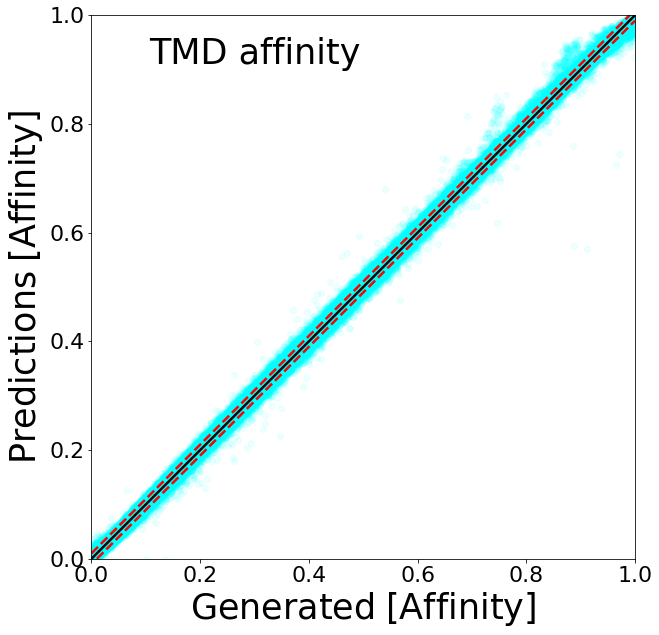

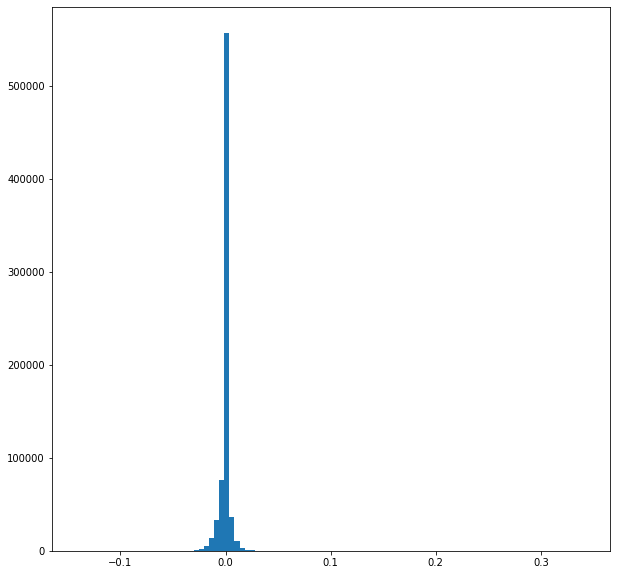

############ 


----------------------------

Network Plots
tracing network dimentions.


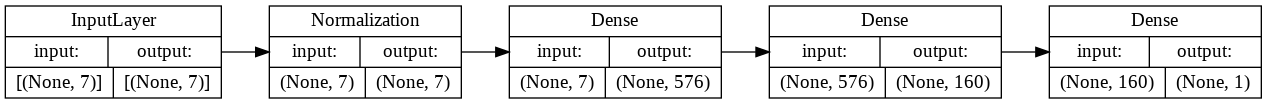

tracing activation functions


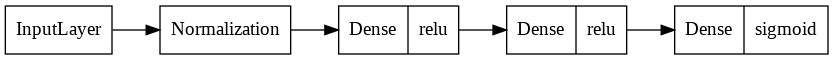

CPU times: user 1min 39s, sys: 5.92 s, total: 1min 45s
Wall time: 1min 49s


In [16]:
%%time

# region_name = 'collinear'
# region_name = 'target'
# region_name = 'current'
region_name = 'TMD'
lable_name = 'tmdaff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'TMD affinity'

scot_plot(mld_path, file_path, lable_name, title)

# Current

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f8408a1a490>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f8408a1a9d0>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f8408a20990>
     <function relu at 0x7f840d4305f0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f83ff6e42d0>
     <function relu at 0x7f840d4305f0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f840895a350>
     <function sigmoid at 0x7f840d430b00>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

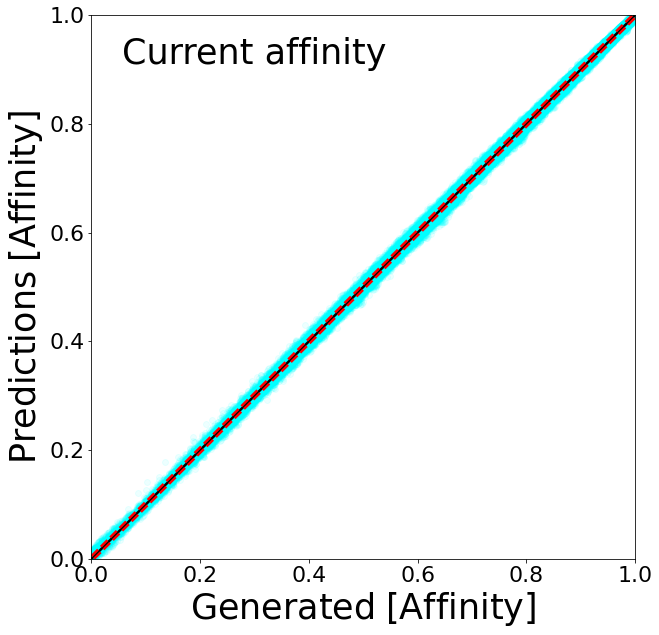

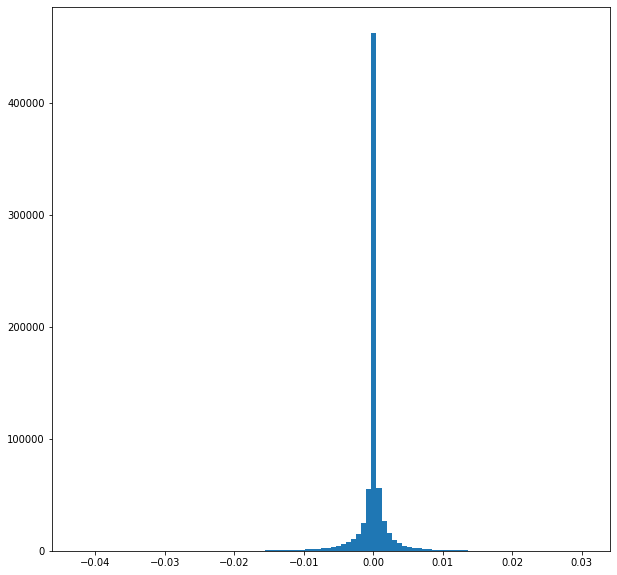

############ 


----------------------------

Network Plots
tracing network dimentions.


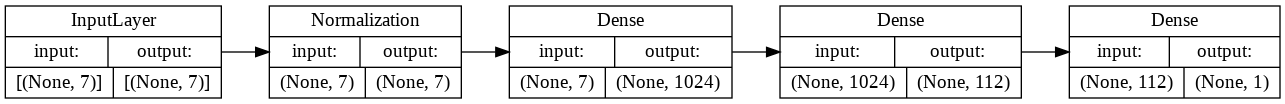

tracing activation functions


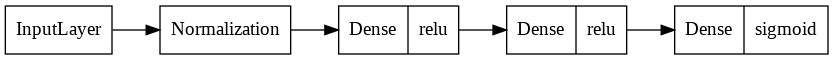

CPU times: user 1min 49s, sys: 6.15 s, total: 1min 56s
Wall time: 1min 49s


In [17]:
%%time

# region_name = 'collinear'
# region_name = 'target'
region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Current affinity'

scot_plot(mld_path, file_path, lable_name, title)

# Collinear

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f8405af4fd0>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f8405b0fb50>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f840028f6d0>
     <function relu at 0x7f840d4305f0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f84083d7f90>
     <function relu at 0x7f840d4305f0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f8405af9c50>
     <function sigmoid at 0x7f840d430b00>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

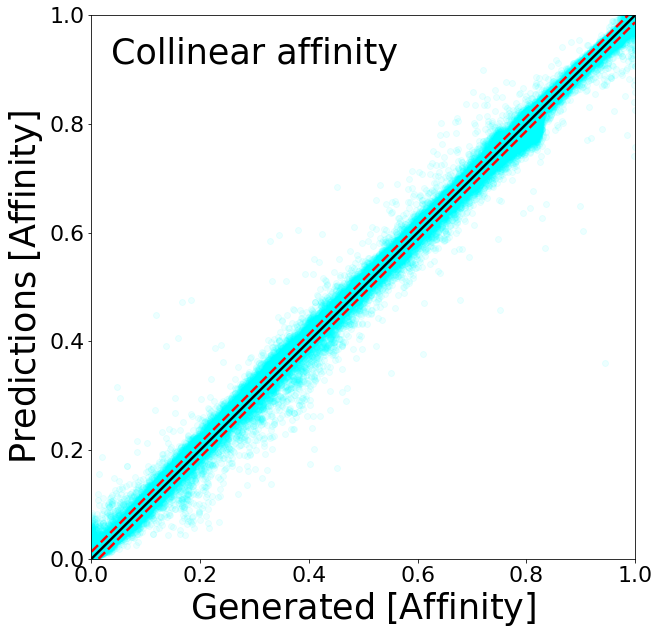

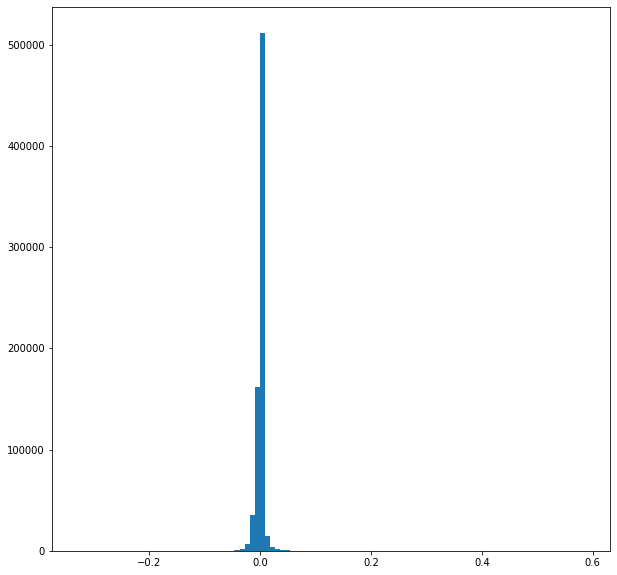

############ 


----------------------------

Network Plots
tracing network dimentions.


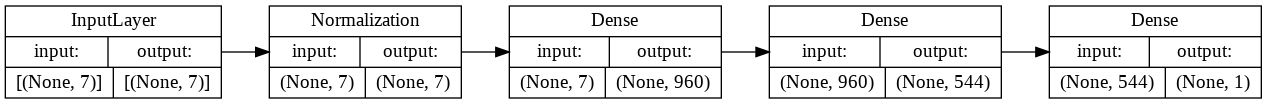

tracing activation functions


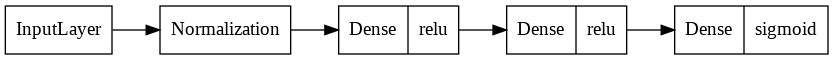

CPU times: user 2min 51s, sys: 7.94 s, total: 2min 59s
Wall time: 2min 53s


In [18]:
%%time

region_name = 'collinear'
# region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Collinear affinity'

scot_plot(mld_path, file_path, lable_name, title)

# target

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f84072b18d0>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f8405eba950>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f8408b68a90>
     <function relu at 0x7f840d4305f0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f84072a1b10>
     <function relu at 0x7f840d4305f0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f8408da2210>
     <function sigmoid at 0x7f840d430b00>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

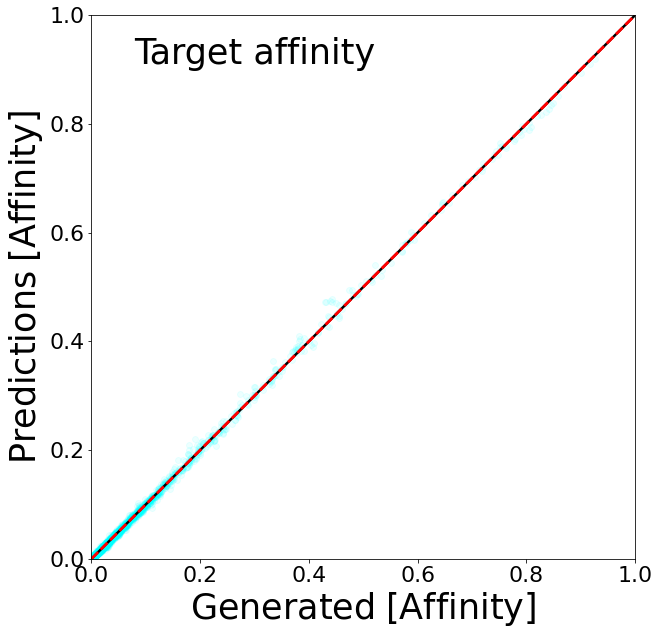

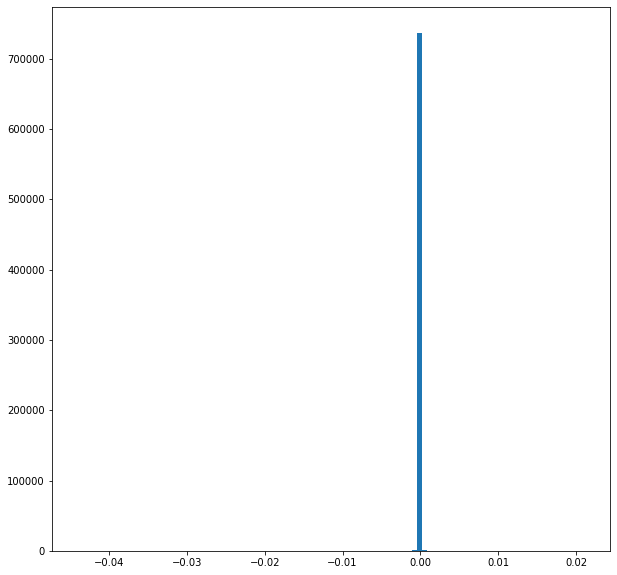

############ 


----------------------------

Network Plots
tracing network dimentions.


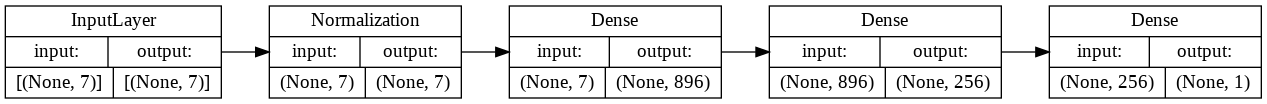

tracing activation functions


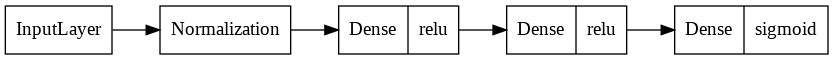

CPU times: user 2min 11s, sys: 6.08 s, total: 2min 17s
Wall time: 2min 17s


In [19]:
%%time

# region_name = 'collinear'
region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Target affinity'

scot_plot(mld_path, file_path, lable_name, title)

# soft

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f8407749250>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f8407749550>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f8406a82e10>
     <function relu at 0x7f840d4305f0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f840772e7d0>
     <function relu at 0x7f840d4305f0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f840772e910>
     <function sigmoid at 0x7f840d430b00>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

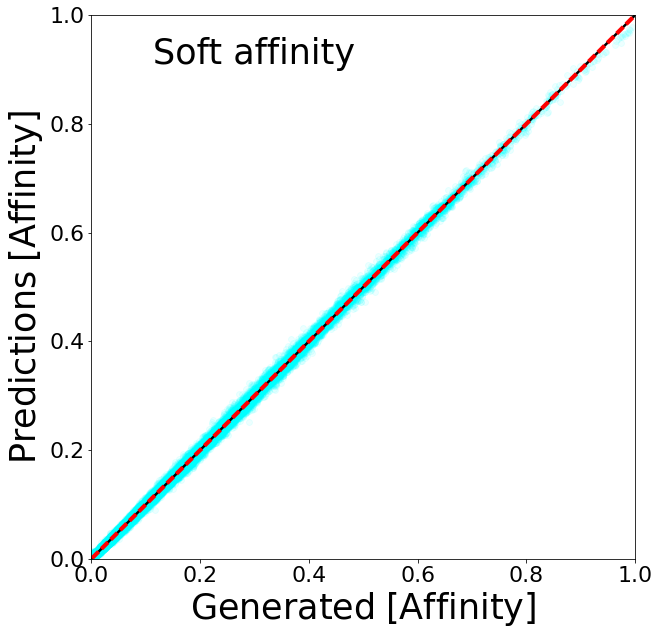

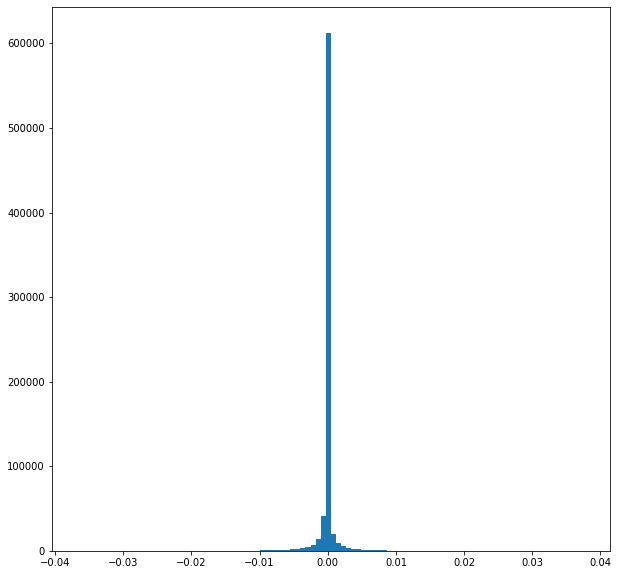

############ 


----------------------------

Network Plots
tracing network dimentions.


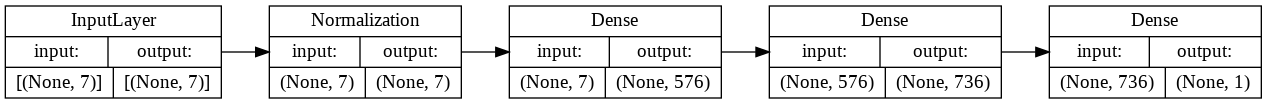

tracing activation functions


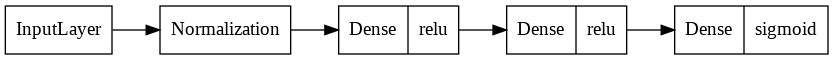

CPU times: user 2min 40s, sys: 8.16 s, total: 2min 48s
Wall time: 2min 8s


In [20]:
%%time

# region_name = 'collinear'
region_name = 'soft'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Soft affinity'

scot_plot(mld_path, file_path, lable_name, title)